In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as numpy
import cv2
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn
import torchvision.transforms as transforms
import imageio
from torch.autograd import Variable

In [2]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        self.conv1_2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        self.conv1_3 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),

            nn.LeakyReLU(0.1, inplace=True),

        )
        
        self.conv2_1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.conv3_1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
        self.conv3_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
        
        self.conv3_3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)

        )   
        
        
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),

            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )   
    
        
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(128*2, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),

            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )   

        self.fc1 = nn.Linear(256*8*4*2, 2)

        
        
        
    def forward(self, x, y, z):
        outx = self.conv1_1(x)
        outx = self.conv2_1(outx)
        outx = self.conv3_1(outx)
        outx = self.conv4(outx)
        outx = outx.view(outx.size(0), -1)
        
        outy = self.conv1_2(y)
        outy = self.conv2_2(outy)
        outy = self.conv3_2(outy)

        
        outz = self.conv1_3(z)
        outz = self.conv2_3(outz)
        outz = self.conv3_3(outz)
        
        oyz=torch.cat([outy,outz],1)
        
        oyz = self.conv5(oyz)
        oyz = oyz.view(oyz.size(0), -1)
        
        oo=torch.cat([outx,oyz],1)
    
        out = self.fc1(oo)
        
        return out

In [3]:
model=CNN()
model

CNN(
  (conv1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv1_2): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv1_3): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): MaxPool

In [4]:
model_path='./trained_final_ntw.pth'

use_gpu=torch.cuda.is_available()

if use_gpu:

    print('GPU Mode Acitavted')
    model = model.cuda()
    model.cuda()
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    model.load_state_dict(torch.load(model_path))
    
else:
    
    print('CPU Mode Acitavted')
    state_dict = torch.load(model_path,map_location='cpu')
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)

CPU Mode Acitavted


In [5]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [6]:

original_path1= './lytro-03-A.jpg'  
original_path2= './lytro-03-B.jpg'

# original_path1= './flower1.tif'  
# original_path2= './flower2.tif'


100%|██████████| 123/123 [25:12<00:00, 12.30s/it]


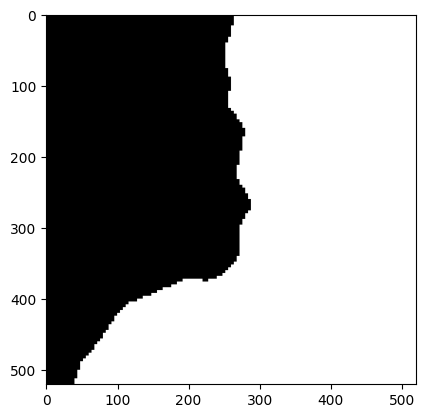

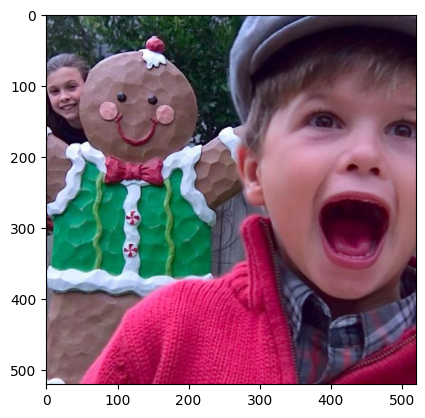

In [7]:
tfms1 = transforms.Compose([
    transforms.Resize((64, 32)), 
    transforms.ToTensor(), 
    transforms.Normalize([0.45 ], [0.1])
])

tfms2 = transforms.Compose([
    transforms.Resize((64, 32)),
    transforms.ToTensor(),
    transforms.Normalize([ 0.050], [ 0.09])
])
tfms3 = transforms.Compose([
    transforms.Resize((64, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.06], [ 0.09])
])

img1_org = Image.open(original_path1)
img2_org = Image.open(original_path2)
img1_org = np.asarray(img1_org)
img2_org = np.asarray(img2_org)
height=img1_org.shape[0]
width=img2_org.shape[1]

windows_size=32
# stride can be set as 2 or 4 or 8 based on the size of input images
if width>= 500 and height>=500:
    factor=1
    stride=4
else:
    factor=2
    stride=8


    
dim1=(width, height)
dim2 = (int(width*factor), int(height*factor))        
img1 = cv2.resize(img1_org, dim2, interpolation = cv2.INTER_AREA)
img2 = cv2.resize(img2_org, dim2, interpolation = cv2.INTER_AREA)

kernel=np.array([[-1 ,   -2 ,   -1],  [0 ,    0    , 0],  [1 ,    2,     1]])
# img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
if len(img1.shape) == 3:
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
else:
    img1_gray = img1

img1_GY = cv2.filter2D(img1_gray,-1,kernel)
img1_GX = cv2.filter2D(img1_gray,-1,np.transpose(kernel))

# img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
if len(img2.shape) == 3:
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
else:
    img2_gray = img2

img2_GY = cv2.filter2D(img2_gray,-1,kernel)
img2_GX = cv2.filter2D(img2_gray,-1,np.transpose(kernel))

test_image1_1=img1_gray
test_image1_2=img1_GX
test_image1_3=img1_GY

test_image2_1=img2_gray
test_image2_2=img2_GX
test_image2_3=img2_GY


source1=img1
source2=img2

j=0

MAP=np.zeros([img1.shape[0], img1.shape[1]])

score1=0
score2=0
FUSED=np.zeros(test_image1_1.shape)

windowsize_r = windows_size-1
windowsize_c = windows_size-1

map1=np.zeros([img1.shape[0], img1.shape[1]])
map2=np.zeros([img2.shape[0], img2.shape[1]])

for r in tqdm(range(0,img1.shape[0] - windowsize_r, stride)):
    for c in range(0,img1.shape[1] - windowsize_c, stride):
        
        block_test1_1 = test_image1_1[r:r+windowsize_r+1,c:c+windowsize_c+1]
        block_test1_2 = test_image1_2[r:r+windowsize_r+1,c:c+windowsize_c+1]
        block_test1_3 = test_image1_3[r:r+windowsize_r+1,c:c+windowsize_c+1]
        
        block_test2_1 = test_image2_1[r:r+windowsize_r+1,c:c+windowsize_c+1]
        block_test2_2 = test_image2_2[r:r+windowsize_r+1,c:c+windowsize_c+1]
        block_test2_3 = test_image2_3[r:r+windowsize_r+1,c:c+windowsize_c+1]
 
        block1_1= np.concatenate((block_test1_1, block_test2_1), axis=0)
        block2_1= np.concatenate((block_test2_1, block_test1_1), axis=0)  
        block1_1 = Image.fromarray(block1_1, 'L')
        block2_1 = Image.fromarray(block2_1, 'L')
        block1_2= np.concatenate((block_test1_2, block_test2_2), axis=0)
        block2_2= np.concatenate((block_test2_2, block_test1_2), axis=0)  
        block1_2 = Image.fromarray(block1_2, 'L')
        block2_2 = Image.fromarray(block2_2, 'L')
        block1_3= np.concatenate((block_test1_3, block_test2_3), axis=0)
        block2_3= np.concatenate((block_test2_3, block_test1_3), axis=0)  
        block1_3 = Image.fromarray(block1_3, 'L')
        block2_3 = Image.fromarray(block2_3, 'L')
                 
        imout1_1=tfms1(block1_1)
        imout2_1=tfms1(block2_1)
        imout1_2=tfms2(block1_2)
        imout2_2=tfms2(block2_2)
        imout1_3=tfms3(block1_3)
        imout2_3=tfms3(block2_3)
        
        if use_gpu:
            imout1_1=to_var(imout1_1)
            imout2_1=to_var(imout2_1)
            imout1_2=to_var(imout1_2)
            imout2_2=to_var(imout2_2)
            imout1_3=to_var(imout1_3)
            imout2_3=to_var(imout2_3)
        
        imout1_1=(imout1_1)
        imout2_1=(imout2_1)
        imout1_2=(imout1_2)
        imout2_2=(imout2_2)
        imout1_3=(imout1_3)
        imout2_3=(imout2_3)
        
        
        inputs1_1 = imout1_1.unsqueeze(0)
        inputs2_1 = imout2_1.unsqueeze(0)
        inputs1_2 = imout1_2.unsqueeze(0)
        inputs2_2 = imout2_2.unsqueeze(0)
        inputs1_3 = imout1_3.unsqueeze(0)
        inputs2_3 = imout2_3.unsqueeze(0)

        model.eval()

        outputs1 = model(inputs1_1,inputs1_2,inputs1_3)
        _, predicted1 = torch.max(outputs1.data, 1)
        
        score1=predicted1.detach().cpu().numpy()

        model.eval()
        
        outputs2 = model(inputs2_1,inputs2_2,inputs2_3)
        _, predicted2 = torch.max(outputs2.data, 1)
        
        score2=predicted2.detach().cpu().numpy()
        
        map2[r:r+windowsize_r+1,c:c+windowsize_c+1] += 1
        
        if score1 <= score2:
            map1[r:r+windowsize_r+1,c:c+windowsize_c+1] += +1 
      
        else:
            map1[r:r+windowsize_r+1,c:c+windowsize_c+1] += -1
            
map1 = cv2.resize(map1, dim1, interpolation = cv2.INTER_AREA)
test_image1 = img1_org
test_image2 = img2_org
map3=np.zeros([img1_org.shape[0], img2_org.shape[1]])
FUSED=np.zeros(img1_org.shape)
for r in range(0,img1_org.shape[0], 1):
    for c in range(0,img1_org.shape[1], 1):   
        
        if map1[r,c] < 0:
            map3[r,c] =0
            FUSED[r,c]=img2_org[r,c]
            
        else:
            map3[r,c] =1
            FUSED[r,c]=img1_org[r,c]
            
FUSED_8=FUSED.astype(np.uint8)
plt.imshow(map3, cm.gray)
plt.show()
plt.imshow(FUSED_8)
plt.show()
#imageio.imwrite('./output.bmp', FUSED_8)
imageio.imwrite('./output1.jpg', FUSED_8)